# NLE Assignment 1: Books vs DVDs

In this assignment, you will be investigating NLP methods for distinguishing reviews written about books from reviews written about DVDs.

For assessment, you are expected to complete and submit this notebook file.  When answers require code, you may import and use library functions (unless explicitly told otherwise).  All of your own code should be included in the notebook rather than imported from elsewhere.  Written answers should also be included in the notebook.  You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers.  If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data.   In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell.  Otherwise do not change the code in these cells.

In [1]:
candidateno=22001417 #this MUST be updated to your candidate number so that you get a unique data sample

In [2]:
#set up drives for resources. Change the path as necessary

from google.colab import drive
#mount google drive
drive.mount('/content/drive/')
import sys
sys.path.append('/content/drive/My Drive/NLENotebooks/resources/')
from utils import *

Mounted at /content/drive/
Sussex NLTK root directory is /content/drive/My Drive/NLENotebooks/resources


In [3]:
#do not change the code in this cell
#preliminary imports

#for setting up training and testing data
from sussex_nltk.corpus_readers import AmazonReviewCorpusReader
import random

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
from itertools import zip_longest


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the 
            pair is a list of the training data and the second is a list of the test data.
    """
    
    data = list(data)  
    n = len(data)  
    train_indices = random.sample(range(n), int(n * ratio))          
    test_indices = list(set(range(n)) - set(train_indices))    
    train = [data[i] for i in train_indices]           
    test = [data[i] for i in test_indices]             
    return (train, test)                       
 

def feature_extract(review):
    """
    Generate a feature representation for a review
    :param review: AmazonReview object
    :return: dictionary of Boolean features
    """
    return {word:True for word in review.words()}

def get_training_test_data(categories=('book','dvd'),ratio=0.7,seed=candidateno):
    """
    Get training and test data for a given pair of categories and ratio, pre-formatted for use with NB classifier
    :param category: pair of categories of review corpus, two from ["kitchen, "dvd, "book", "electronics"]
    :param ratio: proportion of data to use as training data
    :return: pair of lists 
    """
    random.seed(candidateno)

    train_data=[]
    test_data=[]
    for category in categories:
      reader=AmazonReviewCorpusReader().category(category)    
      train, test = split_data(reader.documents(),ratio=ratio)
   
      train_data+=[(feature_extract(review),category)for review in train]
      test_data+=[(feature_extract(review),category)for review in test]
    random.shuffle(train_data)
    random.shuffle(test_data)

    return train_data,test_data

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [5]:
#do not change the code in this cell
training_data,testing_data=get_training_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 6526
The amount of testing data is 2799
The representation of a single data item is below
({'With': True, 'fiction': True, 'there': True, 'is': True, 'usually': True, 'some': True, 'distance': True, 'between': True, 'the': True, 'reader': True, 'and': True, 'action': True, 'described': True, '.': True, 'After': True, 'all': True, ',': True, 'seated': True, 'in': True, 'a': True, 'comfortable': True, 'chair': True, 'one': True, 'assumes': True, 'pleasant': True, 'surroundings': True, 'But': True, 'such': True, 'not': True, 'case': True, 'with': True, 'this': True, 'novel': True, 'The': True, 'story': True, 'disappeared': True, 'almost': True, 'from': True, 'beginning': True, 'like': True, 'Wedding': True, 'Guest': True, 'Coleridge': True, "'s": True, 'poem': True, 'I': True, 'was': True, 'dragged': True, 'Ohio': True, 'to': True, 'Mississippi': True, 'heat': True, 'of': True, 'summer': True, 'forced': True, 'witness': True, 'things': True, 'did': True, "n'

1) Use your training data to find
a) the top 20 words which occur more frequently in book reviews than in dvd reviews
b) the top 20 words which occur more frequently in dvd reviews than book reviews
Discuss what pre-processing techniques you have applied (or not applied) in answering this question, and why. [20%]

In [6]:
from nltk.probability import FreqDist
from functools import reduce

# define the method to get words
def get_all_words(amazon_reviews):
    return reduce(lambda words,review: words + review.words(), amazon_reviews, [])

# get words from Amazon 
dvd_reader = AmazonReviewCorpusReader().category("dvd")
book_reader = AmazonReviewCorpusReader().category("book")

# split the words as training data
dvd_train, dvd_test = split_data(dvd_reader.documents())
book_train, book_test = split_data(book_reader.documents())
train_data = dvd_train + book_train
test_data = dvd_test + book_test

# show the frequence of training data
book_freqdist = FreqDist(get_all_words(book_train))
dvd_freqdist = FreqDist(get_all_words(dvd_train))

In [8]:
stop = stopwords.words('english')

# define the method to get the different frequent x words in two categories
def most_frequent_words(posfreq,negfreq,topk):
    difference=[(w,f-negfreq.get(w,0)) for (w,f) in posfreq.most_common()]
    sorteddiff=sorted(difference,key=lambda pair:pair[1],reverse=True)
    normalised=[w.lower() for (w,f) in sorteddiff]
    filtered=[w for w in normalised if w.isalpha() and w not in stop]
    return filtered[:topk]

In [9]:
# the top 20 words which occur more frequently in two views
top_book = most_frequent_words(book_freqdist,dvd_freqdist,20)
top_dvd = most_frequent_words(dvd_freqdist,book_freqdist,20)

# show the data more directly
pd.DataFrame({'book review' : top_book, 'dvd review': top_dvd })

,book review,dvd review
0,book,movie
1,read,film
2,books,dvd
3,author,one
4,reading,like
5,reader,watch
6,novel,great
7,written,see
8,writing,show
9,pages,movies


In this part i have compared top 20 words which occur more frequently in two views.



there are **four** word processing:
1.   **tokenization**

 tokenization is the basic processing which change the data to Math problem
2.   **normalization**

 Text normalization is the process of transforming a text into a canonical form. It is important for noisy texts from social media or bogs. In these view posts abbreviations, misspellings and use of out-of-vocabulary words are prevalent.So I have applied it.
3.   **stemming/lemmatisation**

 stemming is very similar to lemmatisation.They are useful for dealing with sparsity issues as well as standardizing vocabulary, but provides no significant benefit for text classification purposes. So I haven't applied it. 
4.   **stop word removal**

 Stop words are a set of commonly used words in a language. Examples of stop words in English are “a”, “the”, “is”, “are” and etc. I think it showed to be non-critical in classification systems, in the different method they will be subtracted. So I haven't applied it. 

2) Design, build and test a word list classifier to classify reviews as being from the book domain or from the dvd domain.  Make sure you discuss 1) how you decide the lengths and contents of the word lists and ii) accuracy, precision and recall of your final classifier.[30%]

In [10]:
from nltk.classify.api import ClassifierI
import random

# build a word list classifier
class SimpleClassifier(ClassifierI): 

    def __init__(self, book, dvd): 
        self._book = book 
        self._dvd = dvd 

    def classify(self, words): 
        score = 0
        
        for word in words:
            if word in self._book:
                score+=1
            if word in self._dvd:
                score-=1
        
        return "dvd" if score < 0 else "book" 

    def batch_classify(self, docs): 
        return [self.classify(doc.words() if hasattr(doc, 'words') else doc) for doc in docs] 

    def labels(self): 
        return ("book", "dvd")

class SimpleClassifier_mf(SimpleClassifier):

  def __init__(self,k):
    self._k=k

  def train(self,book_train,dvd_train):
    self._book=most_frequent_words(book_freqdist,dvd_freqdist,self._k)
    self._dvd=most_frequent_words(dvd_freqdist,book_freqdist,self._k)

myclassifier = SimpleClassifier_mf(1000)
myclassifier.train(book_train,dvd_train)

In [ ]:
myclassifier.batch_classify(dvd_test)

In [ ]:
myclassifier.batch_classify(book_test)

In [11]:
# returns the accuracy of a classifier
def evaluate_wordlist_classifier(cls, book_train, dvd_train):
  '''
  returns: float point number which is the accuracy of the classifier on the test data provided 
  '''
  acc = 0
  for review in book_train:
    acc += 1 if cls.classify(review.words()) == "book" else 0
    
  for review in dvd_train:
    acc += 1 if cls.classify(review.words()) == "dvd" else 0
    
  return acc / (len(book_train) + len(dvd_train) + 0.0)

#
def feature_extract(review):
    return {word:True for word in review.words()}
    
# define confusion matrix function
class ConfusionMatrix:
    def __init__(self,predictions,goldstandard,classes=("book","dvd")):
        (self.c1,self.c2)=classes
        self.TP=0
        self.FP=0
        self.FN=0
        self.TN=0
        for p,g in zip(predictions,goldstandard):
            if g==self.c1:
                if p==self.c1:
                    self.TP+=1
                else:
                    self.FN+=1
            
            elif p==self.c1:
                self.FP+=1
            else:
                self.TN+=1
    
    def precision(self):
        p=self.TP/(self.TP+self.FP)
        return p
    
    def recall(self):
        r=self.TP/(self.TP+self.FN)
        return r


Amazon_train=[(feature_extract(review),'book')for review in book_train]+[(feature_extract(review),'dvd') for review in dvd_train]
Amazon_test=[(feature_extract(review),'book')for review in book_test]+[(feature_extract(review),'dvd') for review in dvd_test]

In [12]:
docs,labels=zip(*Amazon_test)
senti_cm=ConfusionMatrix(myclassifier.classify_many(docs),labels)
mca=evaluate_wordlist_classifier(myclassifier,book_train,dvd_train)
mcp=senti_cm.precision()
mcr=senti_cm.recall()
# accuracy of my classifier
print(mca)
# precision of my classifier
print(mcp)
# reacall of my classifier
print(mcr)

0.7191235059760956
0.8885448916408669
0.24934839270199827


In this part, I have build a classifier which can do some easy classify from dvd review and book review

3) Compare the performance of your word list classifier with a Naive Bayes classifier (e.g., from NLTK).  Make sure you discuss the results. [20%]

In [13]:
def classifier_evaluate(classifier,test_data):
    
    docs,goldstandard=zip(*test_data) #note this neat pythonic way of turning a list of pairs into a pair of lists
    predictions=classifier.classify_many(docs)
    correct=0
    for (prediction,gold) in zip(predictions,goldstandard):
        if prediction ==gold:
            correct+=1
    return correct/len(test_data)

In [14]:
nb_classifier=NBClassifier()
nb_classifier.train(Amazon_train)

In [15]:
NBclassifier = nltk.NaiveBayesClassifier.train(Amazon_train)
docs,labels=zip(*Amazon_test)
nb_cm=ConfusionMatrix(NBclassifier.classify_many(docs),labels,("book","dvd"))
nba=nltk.classify.accuracy(NBclassifier, Amazon_test)
nbp=nb_cm.precision()
nbr=nb_cm.recall()
# accuracy of Naive Bayes classifier
print(nba)
# precision of Naive Bayes classifier
print(nbp)
# reacall of Naive Bayes classifier
print(nbr)

0.9392640228653091
0.9407008086253369
0.9096437880104257


I have tested the data which from two different classifier

 In Naive Bayes classifier,TP=1084, FP=72, TN=1576, FN =67

 and in the classifier I made, TP=295, FP=47, TN=1601, FN =856
 
 it is obviously that Naive Bayes method can predict more True Postive data and it causes the high accuracy. Also, the lower data of False Negative and False Postive lead to the high precisiona and recall.

4) Design and carry out an experiment into the impact of the amount of training data on each of these classifiers.  Make sure you describe design decisions in your experiment, include a graph of your results and discuss your conclusions. [30%] 

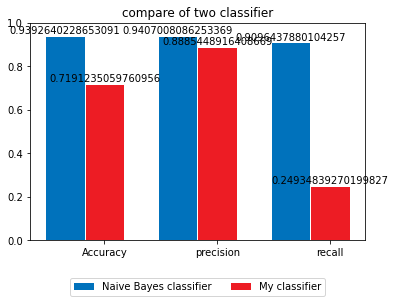

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
 
aclassifier = ('Naive Bayes classifier', 'My classifier')
datatype = ('Accuracy', 'precision', 'recall')
adata = ((nba, nbp, nbr), (mca, mcp, mcr))
 

bar_width = 0.35
 
index = np.arange(len(adata[0]))
# draw Naive Bayes
rects1 = plt.bar(index, adata[0], bar_width, color='#0072BC', label=aclassifier[0])
# draw my classifer
rects2 = plt.bar(index + bar_width, adata[1], bar_width, color='#ED1C24', label=aclassifier[1])
# title of x ray
plt.xticks(index + bar_width, datatype)
# title of y ray
plt.ylim(ymax=1, ymin=0)
# title of the histogram
plt.title('compare of two classifier')
# some sets
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, ncol=5)
 
# add the data labels
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height, height, ha='center', va='bottom')
        # filling the white color
        rect.set_edgecolor('white')
 
add_labels(rects1)
add_labels(rects2)


 I tried to use the matplotlib and learn it by myself, I think the output of **matplotlab** is more exquisite than **panda.**

  the bar chat compare the accuracy, precision ,recall from two classifier. the blue bar stands for Naive Bayes Classifier and the red one stands for the classifier made by myself.

In [ ]:
##This code will word count all of the markdown cells in the notebook saved at filepath
##Running it before providing any answers shows that the questions have a word count of 388

import io
from nbformat import current

filepath="/content/drive/My Drive/NLENotebooks/NLEassignment4/1AfDhmrj3bphuCDv-8IPji2GIJCRyNm7Q0hl-680axhCV38w5KINMmiQGmPs.ipynb"
question_count=388

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

Submission length is 307
